In [1]:
from __future__ import division, print_function
import os
import sys

import numpy as np
from gwbench import basic_relations as br


In [2]:
kwan_path = '../bilby_3g'
if os.path.isdir(kwan_path):
  import sys
  sys.path.append(kwan_path)
  print('Added path: ', kwan_path)

import bilby

import bilby.gw.utils as gwutils


Added path:  ../bilby_3g


In [3]:
m1src = 100.0
m2src= 120.0
theta_jn_deg=0.0
ra_deg=60.0
dec_deg=60.0
psi_deg=60.0
redshift=0.2
duration=np.round(4*br.f_isco_Msolar(m1src+m2src))
fsample=2048.0
fmin=20.
fref=20.
waveform='IMRPhenomXAS'
outdir='./PE_tests/'
margPhase = False
seed = 1290643798
# ifo_list= ['CE', 'CES', 'ET1', 'ET2', 'ET3']
ifo_list= ['CE']



In [4]:
# Set the duration and sampling frequency of the data segment that we're
# going to inject the signal into
sampling_frequency = fsample
sampler = 'dynesty'
# Specify the output directory and the name of the simulation.

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(seed)


In [5]:
# We are going to inject a binary black hole waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# spins of both black holes (a, tilt, phi), etc.
bilby.gw.cosmology._set_default_cosmology()
cosmo = bilby.gw.cosmology.DEFAULT_COSMOLOGY
mtotal = m1src+m2src
q=m2src/m1src
print(q)
tilt_1=0.
tilt_2=0.
chi_1=0.
chi_2=0.
phi_12=0.
phi_jl=0.
z=redshift
dL=cosmo.luminosity_distance(z).value
theta_jn_rad = theta_jn_deg*np.pi/180.0
ra_rad = ra_deg*np.pi/180.0
dec_rad = dec_deg*np.pi/180.0
psi_rad = psi_deg*np.pi/180.0
phase=0.0
gps_time=1577491218.0
m1_det = m1src*(1+z)
m2_det = m2src*(1+z)
Mc_det = bilby.gw.conversion.component_masses_to_chirp_mass(m1_det, m2_det)
total_mass_det = m1_det+m2_det
approx = waveform
label = 'mtotal%.1f_q%.1f_z%.1f_iota%.1f_%s' %(mtotal, 1./q, redshift, theta_jn_deg, approx)
bilby.core.utils.setup_logger(outdir=outdir, label=label)
fref=fref
fmin=fmin


1.2


In [6]:
# injection/simulation of a waveform
injection_parameters = dict(
	chirp_mass = Mc_det, mass_1=m1_det, mass_2=m2_det, chi_1=chi_1, chi_2=chi_2, #tilt_1=tilt_1, tilt_2=tilt_2,
	#phi_12=phi_12, phi_jl=phi_jl, 
	luminosity_distance=dL, theta_jn=theta_jn_rad, psi=psi_rad,
	phase=phase, geocent_time=gps_time, ra=ra_rad, dec=dec_rad, reference_frequency=fref, minimum_frequency=fmin)


In [7]:
# Fixed arguments passed into the source model
# approx: IMRPhenomPv2: standard, (2,2), IMRPhenomXPHM (l,m)=(2,2),...(4,4)
waveform_arguments = dict(waveform_approximant=approx, reference_frequency=fref, minimum_frequency=fmin)

In [8]:
waveform_generator = bilby.gw.WaveformGenerator(
	duration=duration, sampling_frequency=sampling_frequency,
	frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
	parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
	waveform_arguments=waveform_arguments,start_time=injection_parameters['geocent_time'] - duration + 2.0)


19:02 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [9]:
deltaT = gwutils.calculate_time_to_merger(
            frequency=1,
            mass_1=m1_det,
            mass_2=m2_det,
        )

deltaT = np.round(deltaT, 1)
deltaT


268.0

In [10]:
# Set up interferometers.
ifos = bilby.gw.detector.InterferometerList(ifo_list)
for ifo in ifos:
	#ifo.set_strain_data_from_power_spectral_density(
	ifo.set_strain_data_from_zero_noise(
		sampling_frequency=sampling_frequency, duration=duration,
		start_time=injection_parameters['geocent_time'] - duration + 2.0)
	ifo.inject_signal_from_waveform_generator(parameters=injection_parameters, waveform_generator=waveform_generator)
	# ifo.inject_signal(waveform_generator=waveform_generator, parameters=injection_parameters)



19:02 bilby INFO    : Injected signal in CE:
19:02 bilby INFO    :   optimal SNR = 2194.53
19:02 bilby INFO    :   matched filter SNR = 2194.53+0.00j
19:02 bilby INFO    :   chirp_mass = 114.34191394753186
19:02 bilby INFO    :   mass_1 = 120.0
19:02 bilby INFO    :   mass_2 = 144.0
19:02 bilby INFO    :   chi_1 = 0.0
19:02 bilby INFO    :   chi_2 = 0.0
19:02 bilby INFO    :   luminosity_distance = 1011.4196559461382
19:02 bilby INFO    :   theta_jn = 0.0
19:02 bilby INFO    :   psi = 1.0471975511965976
19:02 bilby INFO    :   phase = 0.0
19:02 bilby INFO    :   geocent_time = 1577491218.0
19:02 bilby INFO    :   ra = 1.0471975511965976
19:02 bilby INFO    :   dec = 1.0471975511965976
19:02 bilby INFO    :   reference_frequency = 20.0
19:02 bilby INFO    :   minimum_frequency = 20.0


In [11]:
# For this analysis, we implemenet the standard BBH priors defined, except for
# the definition of the time prior, which is defined as uniform about the
# injected value.
# Furthermore, we decide to sample in total mass and mass ratio, due to the
# preferred shape for the associated posterior distributions.
q_min=0.1
q_max=1.0
total_mass_min = total_mass_det*(0.25)
total_mass_max = total_mass_det*(2.5)
if approx=="IMRPhenomXPHM":
	if q>=0.8:
		chirp_mass_min = Mc_det*(0.75)
		chirp_mass_max = Mc_det*(1.25)
		total_mass_min = total_mass_det*(0.75)
		total_mass_max = total_mass_det*(1.25)
	if (q>=0.4)*(q<0.8):
		chirp_mass_min = Mc_det*(0.75)
		chirp_mass_max = Mc_det*(1.5)
		total_mass_min = total_mass_det*(0.75)
		total_mass_max = total_mass_det*(1.5)
	if q<0.4:
		chirp_mass_min = Mc_det*(0.5)
		chirp_mass_max = Mc_det*(2.0)
		total_mass_min = total_mass_det*(0.5)
		total_mass_max = total_mass_det*(2.0)
dist_min = dL/10.0
dist_max = dL*5.0
# We first output the prior ranges in a text file as a record tracker
BBHprior = \
"""mass_ratio = PowerLaw(name='mass_ratio', minimum=%f, maximum=%f, alpha=-2.0)
total_mass = Uniform(name='total_mass', minimum=%f, maximum=%f)
luminosity_distance = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance', minimum=%f, maximum=%f)
dec = Cosine(name='dec')
ra = Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic')
theta_jn = Sine(name='theta_jn')
psi = Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
delta_phase = Uniform(name='delta_phase', minimum=0, maximum=2 * np.pi, boundary='periodic')
chi_1 = Uniform(name='chi_1', minimum=0, maximum=0.99)
chi_2 = Uniform(name='chi_2', minimum=0, maximum=0.99)
geocent_time = Uniform(name='geocent_time', minimum=%f, maximum=%f)
""" %(q_min, q_max, total_mass_min, total_mass_max, dist_min, dist_max, gps_time-0.1, gps_time+0.1)

with open(outdir+'/%s.prior' %label,'w') as f_prior:
	f_prior.write(BBHprior)

priors = bilby.gw.prior.BBHPriorDict(outdir+'/%s.prior' %label)


In [12]:
# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator, as well the priors.
# The explicit time, distance, and phase marginalizations are turned on to
# improve convergence, and the parameters are recovered by the conversion
# function.
likelihood = bilby.gw.GravitationalWaveTransient(
	interferometers=ifos, waveform_generator=waveform_generator, priors=priors,
	distance_marginalization=True, phase_marginalization=margPhase, time_marginalization=True, distance_marginalization_lookup_table=outdir+'/%s_dist_lookup.npz' %label)


19:02 bilby INFO    : Loaded distance marginalisation lookup table from ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_dist_lookup.npz.


In [13]:
# Run sampler. In this case we're going to use the `dynesty` sampler
# The conversion function will determine the distance, phase and coalescence
# time posteriors in post processing.
result = bilby.run_sampler(
	likelihood=likelihood, priors=priors, sampler=sampler, nlive=60, nact=1, maxmcmc=500,
	injection_parameters=injection_parameters, outdir=outdir,
	label=label,
	conversion_function=bilby.gw.conversion.generate_all_bbh_parameters)



19:02 bilby INFO    : Running for label 'mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS', output will be saved to './PE_tests/'
19:02 bilby INFO    : Using lal version 7.1.3
19:02 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.3;Id: fa9914e5d72cc6168463b5fce79eeba8037404ad;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
19:02 bilby INFO    : Using lalsimulation version 3.0.0
19:02 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.0.0;Id: e8e5ff5aa1ae2676019f59b6785f55284c417fda;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
19:02 bilby INFO    : Search parameters:
19:02 bilby INFO    :   mass_ratio = PowerLaw(alpha=-2.0, minimum=0.1, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
19:02 bilby INFO    :   total_mass = Uniform(minimum=66.0, maximum=660.0, name='total_mass', latex_label='$M$', unit=None, boundary

0it [00:00, ?it/s]

19:02 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 60, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 36, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fa0835abd90>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 500, 'nact': 1, 'print_method': 'tqdm'}
19:02 bilby INFO    : Checkpoint every check_point_delta_t = 600s
19:02 bilby INFO    : Using dynesty version 1.0.1
19:02 bilby INFO    : Using the bilby-

2021it [00:44, 21.06it/s, bound:1838 nc:101 ncall:1.9e+05 eff:1.0% logz-ratio=2404979.72+/-1.07 dlogz:64.873>0.1] 

19:03 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
19:03 bilby WARNING : Axis limits cannot be NaN or Inf
19:03 bilby WARNING : Failed to create dynesty run plot at checkpoint


2125it [10:53,  5.56s/it, bound:1948 nc:101 ncall:2.0e+05 eff:1.0% logz-ratio=2405012.26+/-1.11 dlogz:128.860>0.1]

19:13 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
19:13 bilby WARNING : singular matrix
19:13 bilby WARNING : Failed to create dynesty state plot at checkpoint
19:13 bilby WARNING : singular matrix
19:13 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
19:13 bilby WARNING : singular matrix
19:13 bilby WARNING : Failed to create dynesty run plot at checkpoint


2233it [20:56,  5.56s/it, bound:2058 nc:101 ncall:2.2e+05 eff:1.0% logz-ratio=2405038.86+/-1.12 dlogz:100.321>0.1]

19:23 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
19:23 bilby WARNING : Axis limits 

2343it [31:14,  5.65s/it, bound:2168 nc:101 ncall:2.3e+05 eff:1.0% logz-ratio=2405071.37+/-1.16 dlogz:82.490>0.1] 

19:33 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
19:33 bilby WARNING : Axis limits cannot be NaN or Inf
19:33 bilby WARNING : Failed to create dynesty run plot at checkpoint


2452it [41:38,  5.69s/it, bound:2278 nc:101 ncall:2.4e+05 eff:1.0% logz-ratio=2405118.09+/-1.19 dlogz:34.092>0.1]

19:44 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
19:44 bilby WARNING : Axis limits cannot be NaN or Inf
19:44 bilby WARNING : Failed to create dynesty run plot at checkpoint


2554it [52:24,  7.63s/it, bound:2384 nc:136 ncall:2.5e+05 eff:1.0% logz-ratio=2405141.17+/-1.20 dlogz:23.783>0.1]

19:54 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
19:55 bilby WARNING : Axis limits cannot be NaN or Inf
19:55 bilby WARNING : Failed to create dynesty run plot at checkpoint


2638it [1:02:28,  8.64s/it, bound:2469 nc:235 ncall:2.6e+05 eff:1.0% logz-ratio=2405149.55+/-1.21 dlogz:16.524>0.1]

20:05 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
20:05 bilby WARNING : Axis limits cannot be NaN or Inf
20:05 bilby WARNING : Failed to create dynesty run plot at checkpoint


2730it [1:13:18,  7.14s/it, bound:2567 nc:121 ncall:2.7e+05 eff:1.0% logz-ratio=2405157.11+/-1.22 dlogz:9.293>0.1] 

20:15 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
20:15 bilby WARNING : Axis limits cannot be NaN or Inf
20:15 bilby WARNING : Failed to create dynesty run plot at checkpoint


2807it [1:23:32,  7.49s/it, bound:2649 nc:143 ncall:2.8e+05 eff:1.0% logz-ratio=2405161.50+/-1.23 dlogz:20.606>0.1]

20:26 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
20:26 bilby WARNING : Axis limits cannot be NaN or Inf
20:26 bilby WARNING : Failed to create dynesty run plot at checkpoint


2846it [1:34:10, 16.54s/it, bound:2699 nc:252 ncall:2.9e+05 eff:1.0% logz-ratio=2405163.59+/-1.25 dlogz:20.441>0.1]

20:36 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
20:36 bilby WARNING : Axis limits cannot be NaN or Inf
20:36 bilby WARNING : Failed to create dynesty run plot at checkpoint


2895it [1:44:59, 11.32s/it, bound:2750 nc:189 ncall:3.0e+05 eff:1.0% logz-ratio=2405167.36+/-1.26 dlogz:15.862>0.1]

20:47 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
20:47 bilby WARNING : Axis limits cannot be NaN or Inf
20:47 bilby WARNING : Failed to create dynesty run plot at checkpoint


2969it [1:55:20,  5.84s/it, bound:2824 nc:101 ncall:3.1e+05 eff:0.9% logz-ratio=2405171.42+/-1.27 dlogz:15.672>0.1]

20:57 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
20:57 bilby WARNING : Axis limits cannot be NaN or Inf
20:57 bilby WARNING : Failed to create dynesty run plot at checkpoint


3058it [2:05:22,  7.06s/it, bound:2920 nc:116 ncall:3.3e+05 eff:0.9% logz-ratio=2405177.00+/-1.29 dlogz:30.183>0.1]

21:07 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
21:07 bilby WARNING : Axis limits cannot be NaN or Inf
21:07 bilby WARNING : Failed to create dynesty run plot at checkpoint


3138it [2:15:33,  7.00s/it, bound:3002 nc:120 ncall:3.4e+05 eff:0.9% logz-ratio=2405184.92+/-1.32 dlogz:66.702>0.1]

21:18 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
21:18 bilby WARNING : Axis limits 

3244it [2:26:25,  5.80s/it, bound:3110 nc:101 ncall:3.5e+05 eff:0.9% logz-ratio=2405199.78+/-1.35 dlogz:81.708>0.1]

21:29 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
21:29 bilby WARNING : Axis limits 

3353it [2:37:06,  5.76s/it, bound:3220 nc:101 ncall:3.6e+05 eff:0.9% logz-ratio=2405233.30+/-1.37 dlogz:151.565>0.1]

21:39 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
21:39 bilby WARNING : Axis limits 

3453it [2:48:56, 11.54s/it, bound:3320 nc:101 ncall:3.7e+05 eff:0.9% logz-ratio=2405302.83+/-1.41 dlogz:216.707>0.1]

21:51 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
21:51 bilby WARNING : Axis limits 

3513it [3:00:35, 11.56s/it, bound:3380 nc:101 ncall:3.7e+05 eff:0.9% logz-ratio=2405366.40+/-1.42 dlogz:290.853>0.1]

22:03 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
22:03 bilby WARNING : Axis limits 

3572it [3:12:10, 11.44s/it, bound:3440 nc:101 ncall:3.8e+05 eff:0.9% logz-ratio=2405418.54+/-1.44 dlogz:238.470>0.1]

22:14 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
22:14 bilby WARNING : Axis limits 

3632it [3:23:53, 14.85s/it, bound:3501 nc:202 ncall:3.9e+05 eff:0.9% logz-ratio=2405486.66+/-1.44 dlogz:173.553>0.1]

22:26 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
22:26 bilby WARNING : Axis limits cannot be NaN or Inf
22:26 bilby WARNING : Failed to create dynesty run plot at checkpoint


3689it [3:35:24, 11.41s/it, bound:3561 nc:101 ncall:3.9e+05 eff:0.9% logz-ratio=2405563.01+/-1.45 dlogz:157.503>0.1]

22:37 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
22:38 bilby WARNING : Axis limits 

3744it [3:47:05, 11.56s/it, bound:3621 nc:101 ncall:4.0e+05 eff:0.9% logz-ratio=2405607.71+/-1.46 dlogz:115.785>0.1]

22:49 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
22:49 bilby WARNING : Axis limits cannot be NaN or Inf
22:49 bilby WARNING : Failed to create dynesty run plot at checkpoint


3851it [3:57:48,  5.28s/it, bound:3731 nc:101 ncall:4.1e+05 eff:0.9% logz-ratio=2405670.55+/-1.48 dlogz:104.098>0.1]

23:00 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
23:00 bilby WARNING : Axis limits 

3971it [4:08:20,  5.30s/it, bound:3851 nc:101 ncall:4.2e+05 eff:0.9% logz-ratio=2405726.59+/-1.50 dlogz:45.653>0.1] 

23:10 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
23:10 bilby WARNING : Axis limits cannot be NaN or Inf
23:10 bilby WARNING : Failed to create dynesty run plot at checkpoint


4081it [4:18:24,  5.35s/it, bound:3961 nc:101 ncall:4.3e+05 eff:0.9% logz-ratio=2405755.16+/-1.51 dlogz:29.592>0.1]

23:20 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
23:21 bilby WARNING : Axis limits cannot be NaN or Inf
23:21 bilby WARNING : Failed to create dynesty run plot at checkpoint


4188it [4:28:30,  5.41s/it, bound:4073 nc:101 ncall:4.4e+05 eff:0.9% logz-ratio=2405767.47+/-1.52 dlogz:16.022>0.1]

23:31 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
23:31 bilby WARNING : Axis limits cannot be NaN or Inf
23:31 bilby WARNING : Failed to create dynesty run plot at checkpoint


4289it [4:38:51, 11.29s/it, bound:4184 nc:301 ncall:4.6e+05 eff:0.9% logz-ratio=2405775.20+/-1.53 dlogz:10.440>0.1]

23:41 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
23:41 bilby WARNING : Axis limits cannot be NaN or Inf
23:41 bilby WARNING : Failed to create dynesty run plot at checkpoint


4351it [4:49:50, 12.11s/it, bound:4256 nc:220 ncall:4.7e+05 eff:0.9% logz-ratio=2405777.49+/-1.54 dlogz:9.670>0.1] 

23:52 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
23:52 bilby WARNING : Axis limits cannot be NaN or Inf
23:52 bilby WARNING : Failed to create dynesty run plot at checkpoint


4394it [5:00:10, 14.88s/it, bound:4305 nc:281 ncall:4.8e+05 eff:0.9% logz-ratio=2405778.87+/-1.54 dlogz:9.356>0.1]

00:02 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
00:02 bilby WARNING : Axis limits cannot be NaN or Inf
00:02 bilby WARNING : Failed to create dynesty run plot at checkpoint


4428it [5:11:00, 23.75s/it, bound:4345 nc:424 ncall:4.9e+05 eff:0.9% logz-ratio=2405780.11+/-1.55 dlogz:19.943>0.1]

00:13 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
00:13 bilby WARNING : Axis limits cannot be NaN or Inf
00:13 bilby WARNING : Failed to create dynesty run plot at checkpoint


4455it [5:21:09, 22.89s/it, bound:4372 nc:430 ncall:5.0e+05 eff:0.9% logz-ratio=2405781.41+/-1.56 dlogz:43.378>0.1]

00:23 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
00:23 bilby WARNING : singular matrix
00:23 bilby WARNING : Failed to create dynesty state plot at checkpoint
00:23 bilby WARNING : singular matrix
00:23 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
00:23 bilby WARNING : singular matrix
00:23 bilby WARNING : Failed to create dynesty run plot at checkpoint


4485it [5:31:35, 19.12s/it, bound:4402 nc:347 ncall:5.1e+05 eff:0.9% logz-ratio=2405783.34+/-1.57 dlogz:40.979>0.1]

00:34 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
00:34 bilby WARNING : Axis limits 

4522it [5:41:47, 14.61s/it, bound:4439 nc:266 ncall:5.2e+05 eff:0.9% logz-ratio=2405786.75+/-1.58 dlogz:36.970>0.1]

00:44 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
00:44 bilby WARNING : Axis limits cannot be NaN or Inf
00:44 bilby WARNING : Failed to create dynesty run plot at checkpoint


4572it [5:52:08, 10.62s/it, bound:4489 nc:181 ncall:5.4e+05 eff:0.9% logz-ratio=2405791.52+/-1.59 dlogz:50.806>0.1]

00:54 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
00:54 bilby WARNING : singular matrix
00:54 bilby WARNING : Failed to create dynesty state plot at checkpoint
00:54 bilby WARNING : singular matrix
00:54 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
00:54 bilby WARNING : singular matrix
00:54 bilby WARNING : Failed to create dynesty run plot at checkpoint


4653it [6:03:04,  6.10s/it, bound:4571 nc:113 ncall:5.5e+05 eff:0.8% logz-ratio=2405807.01+/-1.61 dlogz:111.963>0.1]

01:05 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
01:05 bilby WARNING : Axis limits 

4762it [6:13:19,  5.52s/it, bound:4681 nc:101 ncall:5.6e+05 eff:0.9% logz-ratio=2405861.32+/-1.65 dlogz:321.064>0.1]

01:15 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
01:15 bilby WARNING : Axis limits cannot be NaN or Inf
01:15 bilby WARNING : Failed to create dynesty run plot at checkpoint


4871it [6:23:30,  5.53s/it, bound:4791 nc:101 ncall:5.7e+05 eff:0.9% logz-ratio=2406006.76+/-1.66 dlogz:657.171>0.1]

01:26 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
01:26 bilby WARNING : Axis limits 

4981it [6:33:42,  5.53s/it, bound:4901 nc:101 ncall:5.8e+05 eff:0.9% logz-ratio=2406236.26+/-1.69 dlogz:446.268>0.1]

01:36 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
01:36 bilby WARNING : Axis limits 

5091it [6:43:55,  5.54s/it, bound:5011 nc:101 ncall:5.9e+05 eff:0.9% logz-ratio=2406456.28+/-1.71 dlogz:551.793>0.1]

01:46 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
01:46 bilby WARNING : Axis limits 

5201it [6:54:08,  5.56s/it, bound:5121 nc:101 ncall:6.0e+05 eff:0.9% logz-ratio=2406639.13+/-1.72 dlogz:365.028>0.1]

01:56 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
01:56 bilby WARNING : Axis limits 

5311it [7:04:23,  5.54s/it, bound:5231 nc:101 ncall:6.1e+05 eff:0.9% logz-ratio=2406812.23+/-1.73 dlogz:279.907>0.1]

02:06 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
02:07 bilby WARNING : Axis limits 

5420it [7:14:40,  5.52s/it, bound:5341 nc:101 ncall:6.3e+05 eff:0.9% logz-ratio=2406944.59+/-1.75 dlogz:273.987>0.1]

02:17 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
02:17 bilby WARNING : singular matrix
02:17 bilby WARNING : Failed to create dynesty state plot at checkpoint
02:17 bilby WARNING : singular matrix
02:17 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
02:17 bilby WARNING : singular matrix
02:17 bilby WARNING : Failed to create dynesty run plot at checkpoint


5529it [7:24:52,  5.59s/it, bound:5451 nc:101 ncall:6.4e+05 eff:0.9% logz-ratio=2407034.36+/-1.76 dlogz:182.387>0.1]

02:27 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
02:27 bilby WARNING : Axis limits cannot be NaN or Inf
02:27 bilby WARNING : Failed to create dynesty run plot at checkpoint


5639it [7:35:05,  5.55s/it, bound:5561 nc:101 ncall:6.5e+05 eff:0.9% logz-ratio=2407139.34+/-1.79 dlogz:221.288>0.1]

02:37 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
02:37 bilby WARNING : Axis limits 

5749it [7:45:18,  5.52s/it, bound:5671 nc:101 ncall:6.6e+05 eff:0.9% logz-ratio=2407238.63+/-1.79 dlogz:154.426>0.1]

02:47 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
02:47 bilby WARNING : Axis limits 

5859it [7:55:30,  5.54s/it, bound:5781 nc:101 ncall:6.7e+05 eff:0.9% logz-ratio=2407342.38+/-1.81 dlogz:124.664>0.1]

02:58 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
02:58 bilby WARNING : Axis limits 

5969it [8:05:42,  5.53s/it, bound:5891 nc:101 ncall:6.8e+05 eff:0.9% logz-ratio=2407396.31+/-1.83 dlogz:143.314>0.1]

03:08 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
03:08 bilby WARNING : Axis limits 

6077it [8:15:55,  5.54s/it, bound:6001 nc:101 ncall:6.9e+05 eff:0.9% logz-ratio=2407476.92+/-1.85 dlogz:295.106>0.1]

03:18 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
03:18 bilby WARNING : Axis limits 

6187it [8:26:07,  5.53s/it, bound:6111 nc:101 ncall:7.0e+05 eff:0.9% logz-ratio=2407602.89+/-1.88 dlogz:191.351>0.1]

03:28 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
03:28 bilby WARNING : singular matrix
03:28 bilby WARNING : Failed to create dynesty state plot at checkpoint
03:28 bilby WARNING : singular matrix
03:28 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
03:28 bilby WARNING : Axis limits cannot be NaN or Inf
03:28 bilby WARNING : Failed to create dynesty run plot at checkpoint


6296it [8:36:48,  5.90s/it, bound:6221 nc:101 ncall:7.1e+05 eff:0.9% logz-ratio=2407726.72+/-1.89 dlogz:93.431>0.1] 

03:39 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
03:39 bilby WARNING : Axis limits cannot be NaN or Inf
03:39 bilby WARNING : Failed to create dynesty run plot at checkpoint


6406it [8:47:47,  5.96s/it, bound:6331 nc:101 ncall:7.3e+05 eff:0.9% logz-ratio=2407777.62+/-1.89 dlogz:58.793>0.1] 

03:50 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
03:50 bilby WARNING : Axis limits cannot be NaN or Inf
03:50 bilby WARNING : Failed to create dynesty run plot at checkpoint


6516it [8:58:36,  5.69s/it, bound:6441 nc:101 ncall:7.4e+05 eff:0.9% logz-ratio=2407806.61+/-1.90 dlogz:32.636>0.1]

04:01 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
04:01 bilby WARNING : Axis limits cannot be NaN or Inf
04:01 bilby WARNING : Failed to create dynesty run plot at checkpoint


6625it [9:08:57,  5.56s/it, bound:6551 nc:101 ncall:7.5e+05 eff:0.9% logz-ratio=2407824.57+/-1.91 dlogz:13.099>0.1]

04:11 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
04:11 bilby WARNING : Axis limits cannot be NaN or Inf
04:11 bilby WARNING : Failed to create dynesty run plot at checkpoint


6735it [9:19:13,  5.52s/it, bound:6661 nc:101 ncall:7.6e+05 eff:0.9% logz-ratio=2407831.73+/-1.91 dlogz:7.527>0.1] 

04:21 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
04:21 bilby WARNING : Axis limits cannot be NaN or Inf
04:21 bilby WARNING : Failed to create dynesty run plot at checkpoint


6844it [9:29:25,  5.51s/it, bound:6771 nc:101 ncall:7.7e+05 eff:0.9% logz-ratio=2407834.97+/-1.92 dlogz:2.900>0.1]

04:32 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
04:32 bilby WARNING : Axis limits cannot be NaN or Inf
04:32 bilby WARNING : Failed to create dynesty run plot at checkpoint


6954it [9:39:36,  5.50s/it, bound:6881 nc:101 ncall:7.8e+05 eff:0.9% logz-ratio=2407836.27+/-1.93 dlogz:1.160>0.1]

04:42 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
04:42 bilby WARNING : Axis limits cannot be NaN or Inf
04:42 bilby WARNING : Failed to create dynesty run plot at checkpoint


7059it [9:49:44,  7.16s/it, bound:6991 nc:202 ncall:7.9e+05 eff:0.9% logz-ratio=2407836.64+/-1.93 dlogz:0.369>0.1]

04:52 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
04:52 bilby INFO    : Writing 163 current samples to ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_samples.dat
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
04:52 bilby WARNING : Axis limits cannot be NaN or Inf
04:52 bilby WARNING : Failed to create dynesty run plot at checkpoint


7131it [10:00:34,  7.73s/it, bound:7079 nc:138 ncall:8.0e+05 eff:0.9% logz-ratio=2407836.75+/-1.93 dlogz:0.204>0.1]

05:03 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
05:03 bilby INFO    : Writing 240 current samples to ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_samples.dat
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
05:03 bilby WARNING : Axis limits cannot be NaN or Inf
05:03 bilby WARNING : Failed to create dynesty run plot at checkpoint


7191it [10:11:09, 13.79s/it, bound:7150 nc:257 ncall:8.2e+05 eff:0.9% logz-ratio=2407836.79+/-1.93 dlogz:0.107>0.1]

05:13 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
05:13 bilby INFO    : Writing 234 current samples to ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_samples.dat
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
05:13 bilby WARNING : Axis limits cannot be NaN or Inf
05:13 bilby WARNING : Failed to create dynesty run plot at checkpoint


7194it [10:11:54, 14.36s/it, bound:7153 nc:255 ncall:8.2e+05 eff:0.9% logz-ratio=2407836.80+/-1.93 dlogz:0.102>0.1]

05:14 bilby INFO    : Written checkpoint file ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_resume.pickle
05:14 bilby INFO    : Writing 228 current samples to ./PE_tests//mtotal220.0_q0.8_z0.2_iota0.0_IMRPhenomXAS_samples.dat
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
05:14 bilby WARNING : Axis limits cannot be NaN or Inf
05:14 bilby WARNING : Failed to create dynesty run plot at checkpoint


7194it [10:12:00,  5.10s/it, bound:7153 nc:  1 ncall:8.2e+05 eff:0.9% logz-ratio=2407836.84+/-1.94 dlogz:0.002>0.1]



05:14 bilby INFO    : Sampling time: 16:49:07.307245
05:14 bilby INFO    : Reconstructing marginalised parameters.


100%|██████████| 7254/7254 [07:05<00:00, 17.05it/s]

05:21 bilby INFO    : Generating sky frame parameters.



100%|██████████| 7254/7254 [00:00<00:00, 8982.08it/s]

05:21 bilby INFO    : Computing SNRs for every sample.



100%|██████████| 7254/7254 [01:09<00:00, 104.51it/s]


05:23 bilby INFO    : Summary of results:
nsamples: 7254
ln_noise_evidence: -2407970.065
ln_evidence: -133.223 +/-  1.937
ln_bayes_factor: 2407836.843 +/-  1.937



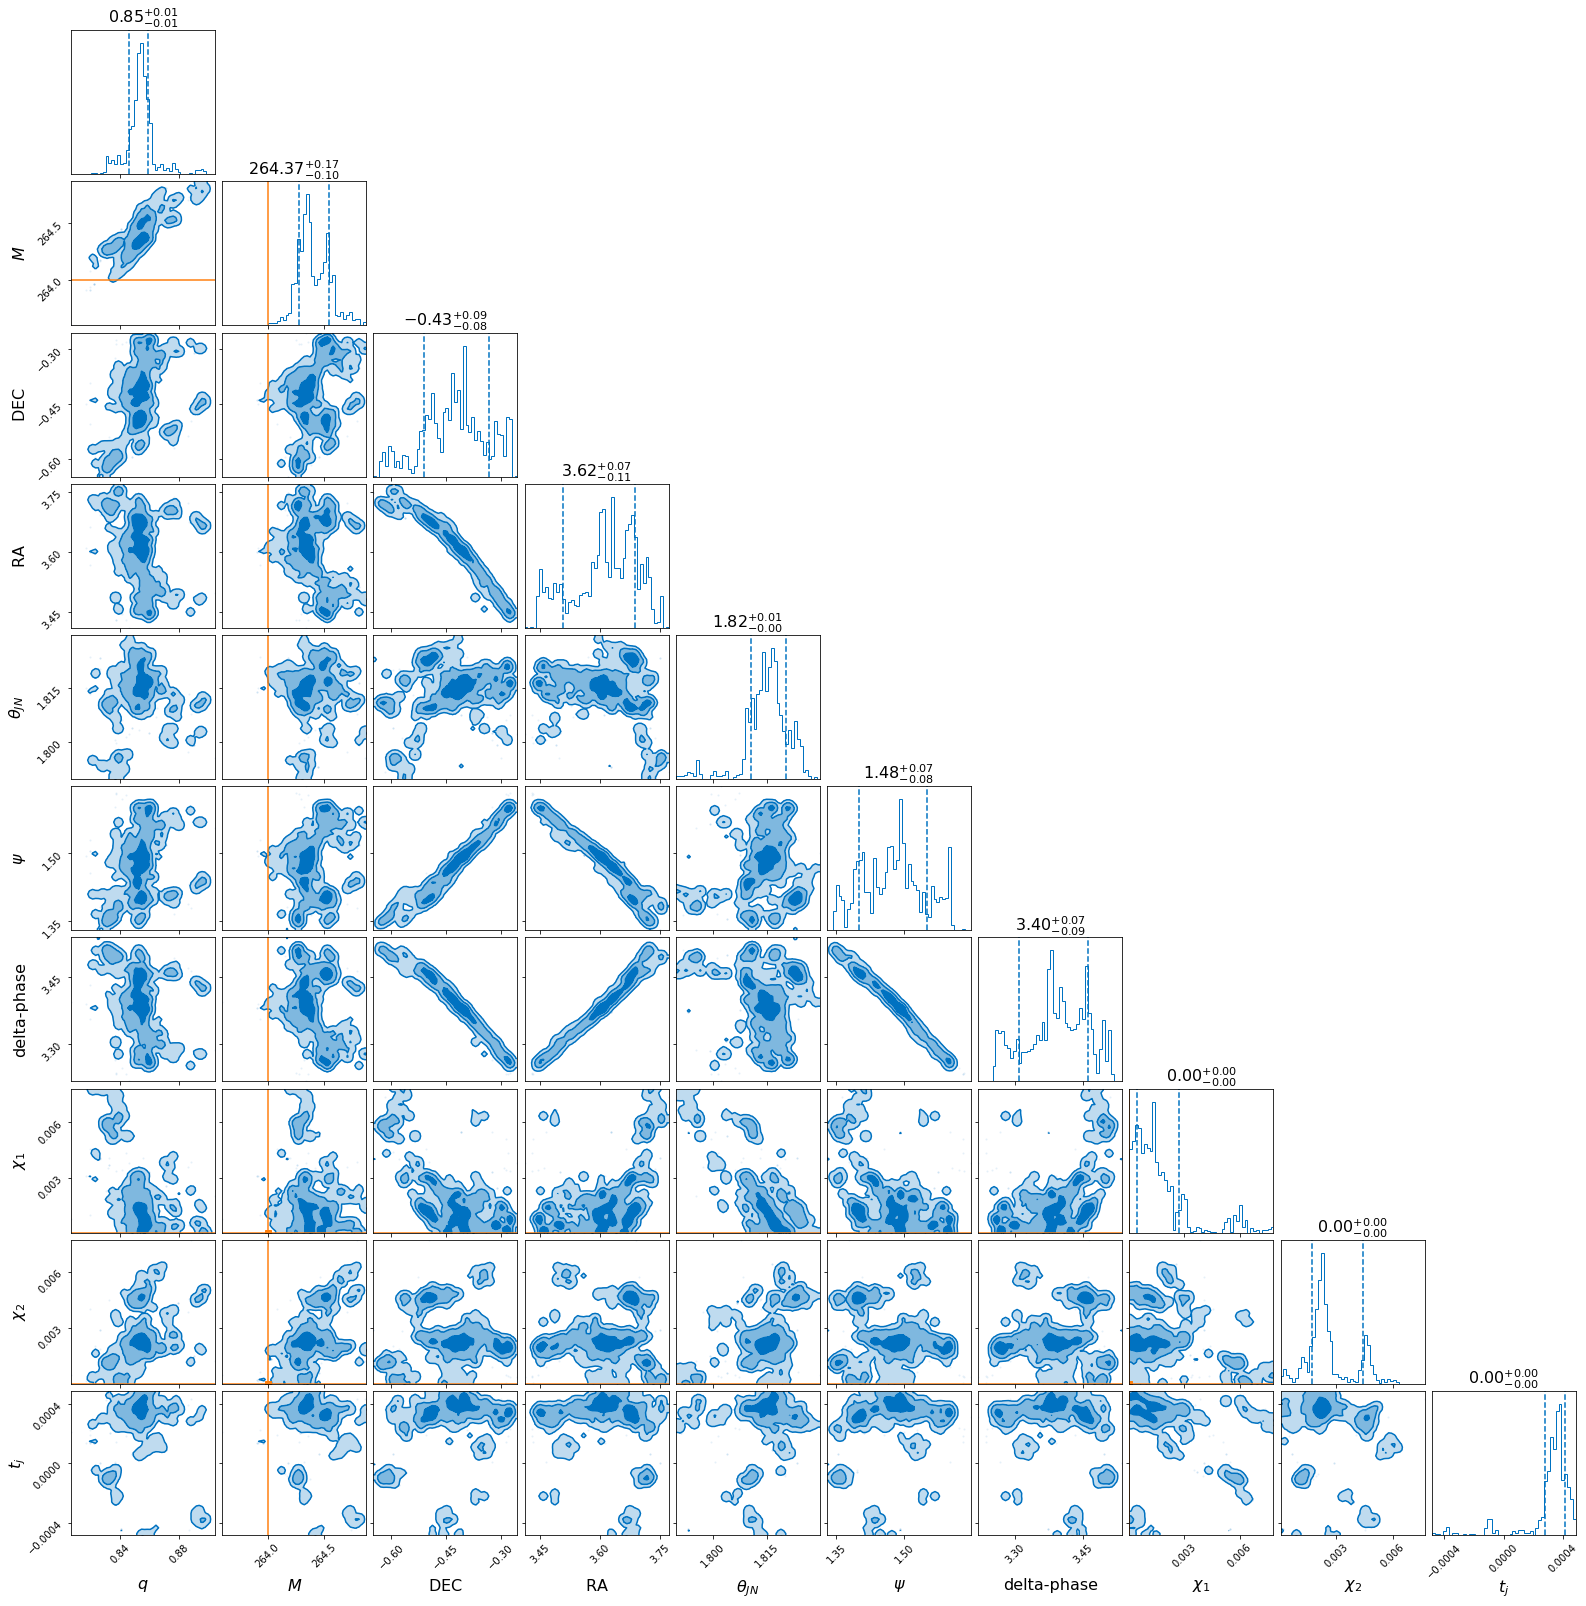

In [14]:
# Make a corner plot.
result.plot_corner()
